In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectKBest
from sklearn.tree import export_graphviz
import pydot
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pylab as pl
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the CSV with pandas
churn_dataframe = pd.read_csv('Churn_Modelling.csv')
target = churn_dataframe['Exited']
X = churn_dataframe.iloc[:,3:13]
target = np.array(target)
display(X.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [3]:
X.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [4]:
#Data Pre-Processing

#Converting Data to numeric
label = LabelEncoder()
X['Gender'] = label.fit_transform(X['Gender'])

# One hot encode the categorical variables
lst = ['Geography']
remove = list()
for i in lst:
    if (X[i].dtype == np.str or X[i].dtype == np.object):
        for j in X[i].unique():
            X[i+'_'+j] = np.where(X[i] == j,1,-1)
        remove.append(i)
X = X.drop(remove, axis=1)
X.head()

X['CreditScoreGivenAge'] = X.CreditScore/(X.Age)
X['TenureByAge'] = X.Tenure/(X.Age)
X['BalanceSalaryRatio'] = X.Balance/X.EstimatedSalary
X.loc[X.HasCrCard == 0, 'HasCrCard'] = -1
X.loc[X.IsActiveMember == 0, 'IsActiveMember'] = -1
X['CreditScore'] = pd.cut(X.CreditScore, bins=[300, 580,670,740,800,850], labels=[0,1,2,3,4], include_lowest=True)
X['CreditScore'] = X['CreditScore'].astype('int64')
# X.head()

continuous_vars = ['Age','Tenure','Balance','NumOfProducts','EstimatedSalary','CreditScoreGivenAge','TenureByAge','BalanceSalaryRatio']

****EXPLORATORY DATA ANALYSIS (EDA)***

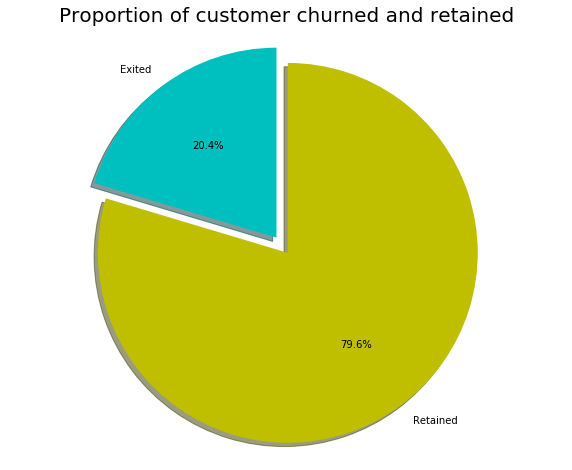

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [5]:
#piechart of number of customers who exited and not exited

df = churn_dataframe.iloc[:,3:14]

labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors='cyan')
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()
df.info()

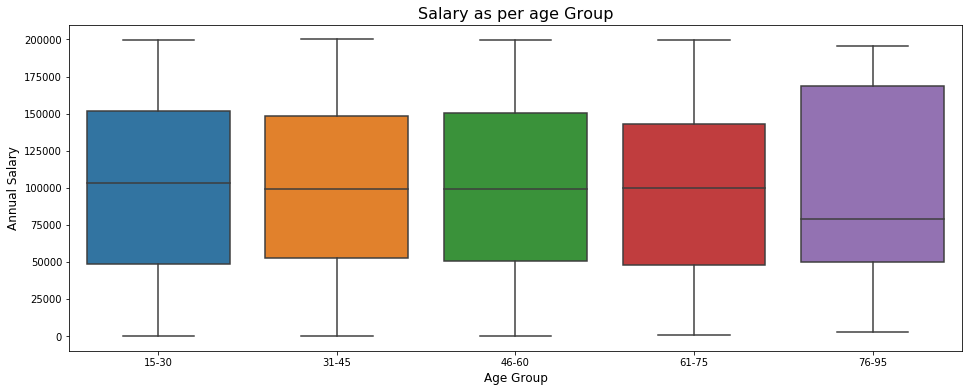

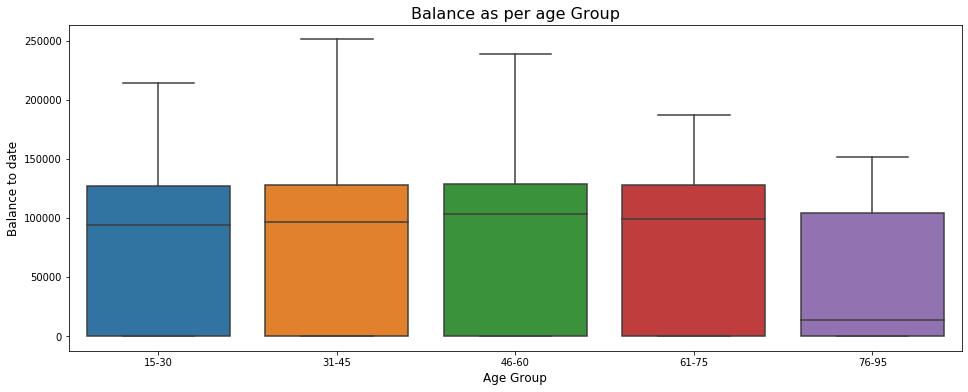

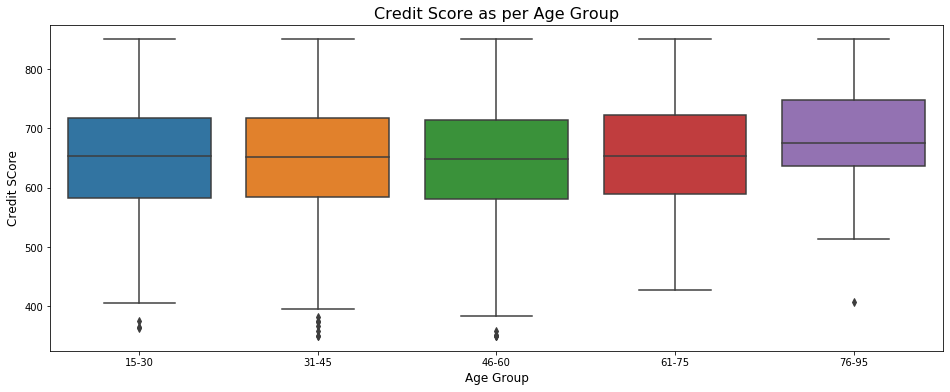

In [6]:
import seaborn as sb

#binning Age
df['A'] = pd.cut(df.Age, bins=[15,31,46,61,76,96], labels=["15-30","31-45","46-60","61-75","76-95"], include_lowest=True)

#Salary vs Age group graph
plt.figure(figsize=(16,6))
sb.boxplot(df.A, df.EstimatedSalary)
plt.ylabel('Annual Salary', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.title('Salary as per age Group', fontsize=16)
plt.show()

#Latest Balance vs Age group graph
plt.figure(figsize=(16,6))
sb.boxplot(df.A, df.Balance)
plt.ylabel('Balance to date', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.title('Balance as per age Group', fontsize=16)
plt.show()

df.head()

#Credit Score vs Age group graph
plt.figure(figsize=(16,6))
sb.boxplot(df.A, df.CreditScore)
plt.ylabel('Credit SCore', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.title('Credit Score as per Age Group', fontsize=16)
plt.show()



Text(0, 0.5, 'Percentage')

<Figure size 1152x432 with 0 Axes>

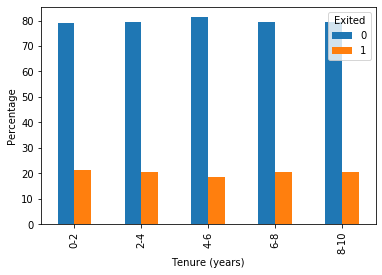

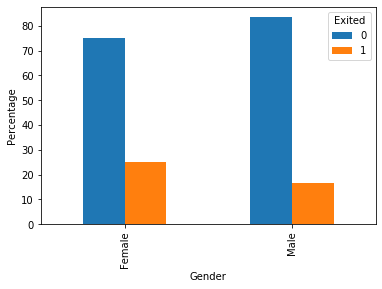

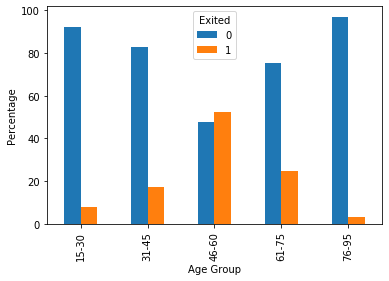

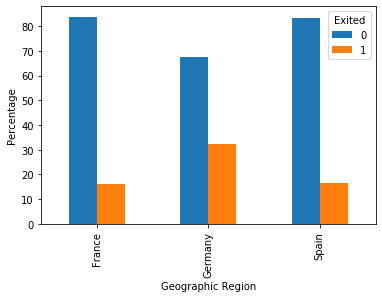

In [7]:
#Bar Graphs

plt.figure(figsize=(16,6))

#Binning Tenure 
df['B'] = pd.cut(df.Tenure, bins=[0,3,5,7,9,11], labels=["0-2","2-4","4-6","6-8","8-10"], include_lowest=True)

#Tenure vs percentage of exit and not exit
tenure_vs_exit = pd.crosstab(df.B,df.Exited).apply(lambda x: (x/x.sum()*100),axis=1)
x=tenure_vs_exit.plot.bar()
x.set_xlabel("Tenure (years)")
x.set_ylabel("Percentage")

#Gender vs percentage of exit and not exit
y=pd.crosstab(df.Gender,df.Exited).apply(lambda x: (x/x.sum()*100),axis=1).plot.bar()
y.set_xlabel("Gender")
y.set_ylabel("Percentage")

#Age group vs percentage of exit and not exit
z = pd.crosstab(df.A,df.Exited).apply(lambda x: (x/x.sum()*100),axis=1).plot.bar()
z.set_xlabel("Age Group")
z.set_ylabel("Percentage")

#Geography vs percentage of exit and not exit
z = pd.crosstab(df.Geography,df.Exited).apply(lambda x: (x/x.sum()*100),axis=1).plot.bar()
z.set_xlabel("Geographic Region")
z.set_ylabel("Percentage")



***EDA END***

In [8]:
#Normalization 

# minMax scaling the continuous variables
minVec = X[continuous_vars].min().copy()
maxVec = X[continuous_vars].max().copy()
X[continuous_vars] = (X[continuous_vars]-minVec)/(maxVec-minVec)
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Spain,Geography_Germany,CreditScoreGivenAge,TenureByAge,BalanceSalaryRatio
0,1,0,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,-1,-1,0.235083,0.085714,0.000000
1,1,0,0.310811,0.1,0.334031,0.000000,-1,1,0.562709,-1,1,-1,0.237252,0.043902,0.000070
2,0,0,0.324324,0.8,0.636357,0.666667,1,-1,0.569654,1,-1,-1,0.168807,0.342857,0.000132
3,2,0,0.283784,0.1,0.000000,0.333333,-1,-1,0.469120,1,-1,-1,0.310859,0.046154,0.000000
4,4,0,0.337838,0.2,0.500246,0.000000,1,1,0.395400,-1,1,-1,0.354739,0.083721,0.000150


In [9]:
#Training , Testing Split
X_train , X_test , y_train , y_test = train_test_split(X , target , test_size = .20 , random_state = 42)

Accuracy :  0.7805
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7963
           1       0.89      0.89      0.89      2037

    accuracy                           0.96     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.96      0.96      0.96     10000



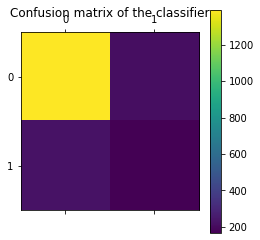

In [10]:
#KNN for k=1
knnClassifier = KNeighborsClassifier(n_neighbors=1)
knnClassifier.fit(X_train , y_train)
y_predict = knnClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  knnClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

Accuracy :  0.8095
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      7963
           1       0.76      0.49      0.60      2037

    accuracy                           0.86     10000
   macro avg       0.82      0.73      0.76     10000
weighted avg       0.86      0.86      0.85     10000



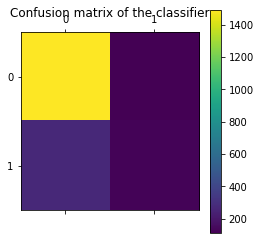

In [11]:
#KNN for k=3
knnClassifier = KNeighborsClassifier(n_neighbors=3)
knnClassifier.fit(X_train , y_train)
y_predict = knnClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  knnClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

Accuracy :  0.812
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7963
           1       0.74      0.36      0.49      2037

    accuracy                           0.84     10000
   macro avg       0.80      0.67      0.70     10000
weighted avg       0.83      0.84      0.82     10000



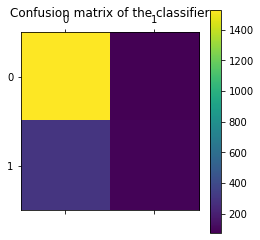

In [12]:
#KNN for k=5
knnClassifier = KNeighborsClassifier(n_neighbors=5)
knnClassifier.fit(X_train , y_train)
y_predict = knnClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  knnClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

Accuracy :  0.8145
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      7963
           1       0.75      0.17      0.28      2037

    accuracy                           0.82     10000
   macro avg       0.79      0.58      0.59     10000
weighted avg       0.81      0.82      0.77     10000



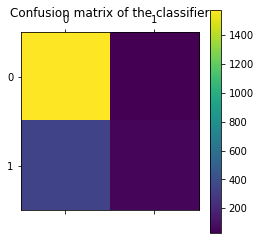

In [13]:
#KNN for k=10
knnClassifier = KNeighborsClassifier(n_neighbors=10)
knnClassifier.fit(X_train , y_train)
y_predict = knnClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  knnClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

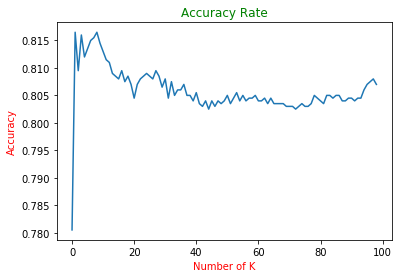

In [14]:
#Accuracy for different K values
accuracy = []
for k in range(1,100):
    knnClassifier = KNeighborsClassifier(n_neighbors=k)
    knnClassifier.fit(X_train , y_train)
    y_predict = knnClassifier.predict(X_test)
    # print(metrics.classification_report(y_test,y_predict))
    acc = metrics.accuracy_score(y_test , y_predict)
    accuracy.append(acc)

plt.plot(np.arange(k),accuracy)
plt.xlabel('Number of K',color='red')
plt.ylabel('Accuracy',color='red')
plt.title('Accuracy Rate',color='green')
plt.show()

Accuracy :  0.832
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7963
           1       0.75      0.02      0.03      2037

    accuracy                           0.80     10000
   macro avg       0.77      0.51      0.46     10000
weighted avg       0.79      0.80      0.71     10000



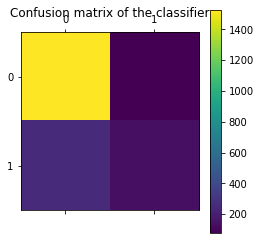

In [15]:
#Naive Bayes
NBClassifier = GaussianNB()
NBClassifier.fit(X_train , y_train)
y_predict = NBClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  knnClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

Accuracy :  0.7925
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7963
           1       0.89      0.90      0.90      2037

    accuracy                           0.96     10000
   macro avg       0.93      0.94      0.94     10000
weighted avg       0.96      0.96      0.96     10000



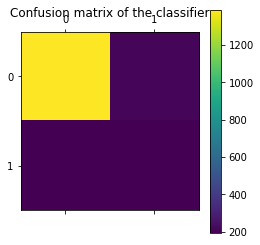

In [16]:
#Decision Tree
DTClassifier = DecisionTreeClassifier(random_state=0)
fit1 = DTClassifier.fit(X_train , y_train)
y_predict = DTClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  DTClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

In [17]:
#For the Visuatlization GraphViz and Pydot libraries need to be installed and Environmental variable needs to be changed



# #Decision Tree Visualization
# export_graphviz(fit1, out_file = 'fit1.dot', rounded = True, precision = 1,filled=True)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('fit1.dot')
# # Write graph to a png file
# graph.write_png('treeDT.png')
# print("Accuracy : ",acc)

Accuracy :  0.8615
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7963
           1       0.96      0.90      0.93      2037

    accuracy                           0.97     10000
   macro avg       0.97      0.95      0.96     10000
weighted avg       0.97      0.97      0.97     10000



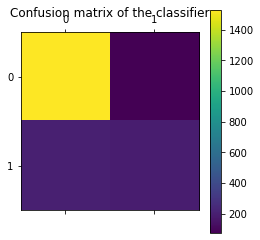

In [18]:
#Random Forest
RFClassifier = RandomForestClassifier(n_estimators=100 , max_features=15)
RFClassifier.fit(X_train , y_train)
y_predict = RFClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  RFClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

In [19]:
#For the Visuatlization GraphViz and Pydot libraries need to be installed and Environmental variable needs to be changed


# # Pull out one tree from the forest
# tree = RFClassifier.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', rounded = True, precision = 1,filled=True)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_pdf('tree2.pdf')
# print("Accuracy : ",acc)

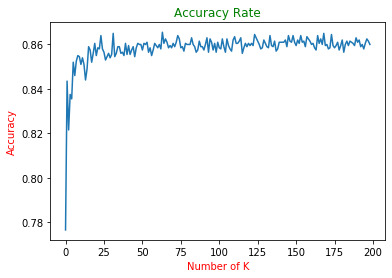

In [20]:
#Accuracy for different number of Trees.
accuracy = []
for k in range(1,200):
    RFClassifier = RandomForestClassifier(n_estimators=k , max_features=15)
    RFClassifier.fit(X_train , y_train)
    y_predict = RFClassifier.predict(X_test)

    # print(metrics.classification_report(y_test,y_predict))
    acc = metrics.accuracy_score(y_test , y_predict)
    accuracy.append(acc)

plt.plot(np.arange(k),accuracy)
plt.xlabel('Number of K',color='red')
plt.ylabel('Accuracy',color='red')
plt.title('Accuracy Rate',color='green')
plt.show()

Accuracy :  0.8575
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7963
           1       0.73      0.52      0.61      2037

    accuracy                           0.86     10000
   macro avg       0.81      0.74      0.76     10000
weighted avg       0.85      0.86      0.85     10000



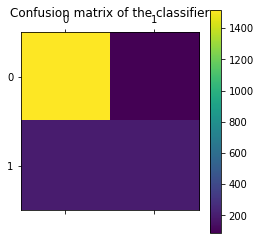

In [21]:
#Artificial Neural Network
ANNClassifier = MLPClassifier()
ANNClassifier.fit(X_train , y_train)
y_predict = ANNClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  ANNClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

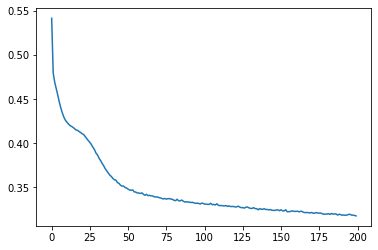

0.8575


In [22]:
loss_value = ANNClassifier.loss_curve_
plt.plot(loss_value)
plt.show()
print(acc)

Accuracy :  0.8085
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7963
           1       0.87      0.03      0.06      2037

    accuracy                           0.80     10000
   macro avg       0.83      0.51      0.47     10000
weighted avg       0.81      0.80      0.72     10000



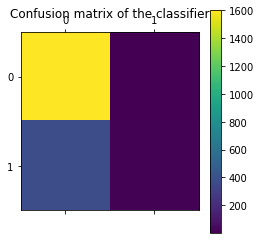

In [23]:
#SVM
SVMClassifier = SVC()
SVMClassifier.fit(X_train , y_train)
y_predict = SVMClassifier.predict(X_test)

# print(metrics.classification_report(y_test,y_predict))
acc = metrics.accuracy_score(y_test , y_predict)
print("Accuracy : ",acc)
print(metrics.classification_report(churn_dataframe.Exited,  SVMClassifier.predict(X.loc[:, X.columns != 'Exited'])))

cm = confusion_matrix(y_test, y_predict)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()